## Parte 1

### Importar y parsear datos

In [104]:
import nltk
import pydot_ng
import graphviz
import gensim
import json
import string
import scipy
import numpy
import pandas
import sklearn
import plotly
import statistics
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [105]:
with open('emol-full.json') as data_file:
    emoldctry=json.load(data_file)
    
with open('la_nacion-full.json') as data_file:
    lndctry=json.load(data_file)

with open('el_mostrador-full.json') as data_file:
    emdctry=json.load(data_file)

with open('la_tercera-full.json') as data_file:
    ltdctry=json.load(data_file)
    
nwspprs=[emoldctry,lndctry,emdctry,ltdctry]

In [106]:
contents=[]
y=[]
for newspaper in nwspprs:
    for article in newspaper:
        contents.append(article['contenido'])
        if (newspaper==emoldctry):
            y.append('emol')
        elif (newspaper==lndctry):
            y.append('la nación')
        elif (newspaper==emdctry):
            y.append('el mostrador')
        elif (newspaper==ltdctry):
            y.append('la tercera')
y=numpy.asarray(y)            
    

In [107]:
documentTokens=[]
stopwords=nltk.corpus.stopwords.words('spanish')
for article in contents:
    tokens=gensim.utils.simple_preprocess(article)
    tokens=[token for token in tokens if token not in stopwords]
    documentTokens.append(tokens)

In [108]:
labelDictionary=gensim.corpora.dictionary.Dictionary()

In [109]:
corpus=[]
for document in documentTokens:
    corpus.append(labelDictionary.doc2bow(document,True))

In [110]:
inv_dict = {v: k for k, v in dict(labelDictionary).items()}


### La siguiente matriz es [documentos]x[palabras]

Le puse sparseMatrix, pero es la TF

In [111]:
sparseMatrix=gensim.matutils.corpus2csc(corpus)

In [112]:
sparseMatrix=sparseMatrix.transpose()

In [113]:
sparseMatrix

<2947x25594 sparse matrix of type '<class 'numpy.float64'>'
	with 396573 stored elements in Compressed Sparse Row format>

### Palabras mas frecuentes por medio

se separan por medio, luego se suman las frecuencias, luego se hace una lista (frecuencia,palabra)

In [11]:
emolMatrix,lnMatrix,emMatrix,ltMatrix=sparseMatrix[0:1000].todense(),sparseMatrix[1000:1832].todense(), \
                                        sparseMatrix[1832:2463].todense(),sparseMatrix[2463:2947].todense()

In [12]:
emolTokenCount=numpy.sum(emolMatrix,0)

In [13]:
emolTopHundredIndeces=numpy.fliplr(emolTokenCount.argsort()).tolist()[0][0:100]

In [14]:
emolTopHundred=[(int(emolTokenCount.tolist()[0][i]),labelDictionary[i]) for i in emolTopHundredIndeces]


In [15]:
lnTokenCount=numpy.sum(lnMatrix,0)

In [16]:
lnTopHundredIndeces=numpy.fliplr(lnTokenCount.argsort()).tolist()[0][0:100]

In [17]:
lnTopHundred=[(int(lnTokenCount.tolist()[0][i]),labelDictionary[i]) for i in lnTopHundredIndeces]

In [18]:
emTokenCount=numpy.sum(emMatrix,0)

In [19]:
emTopHundredIndeces=numpy.fliplr(emTokenCount.argsort()).tolist()[0][0:100]

In [20]:
emTopHundred=[(int(emTokenCount.tolist()[0][i]),labelDictionary[i]) for i in emTopHundredIndeces]

In [21]:
ltTokenCount=numpy.sum(ltMatrix,0)

In [22]:
ltTopHundredIndeces=numpy.fliplr(ltTokenCount.argsort()).tolist()[0][0:100]

In [23]:
ltTopHundred=[(int(ltTokenCount.tolist()[0][i]),labelDictionary[i]) for i in ltTopHundredIndeces]

In [24]:
%matplotlib inline

Datos: 100


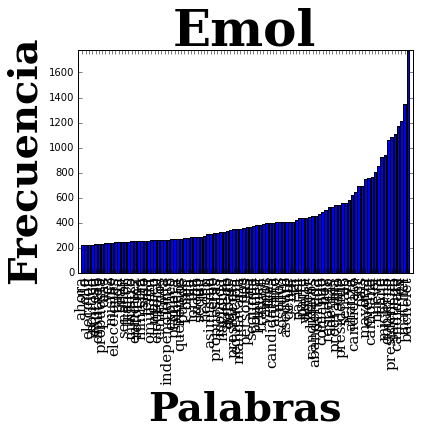

Datos: 100


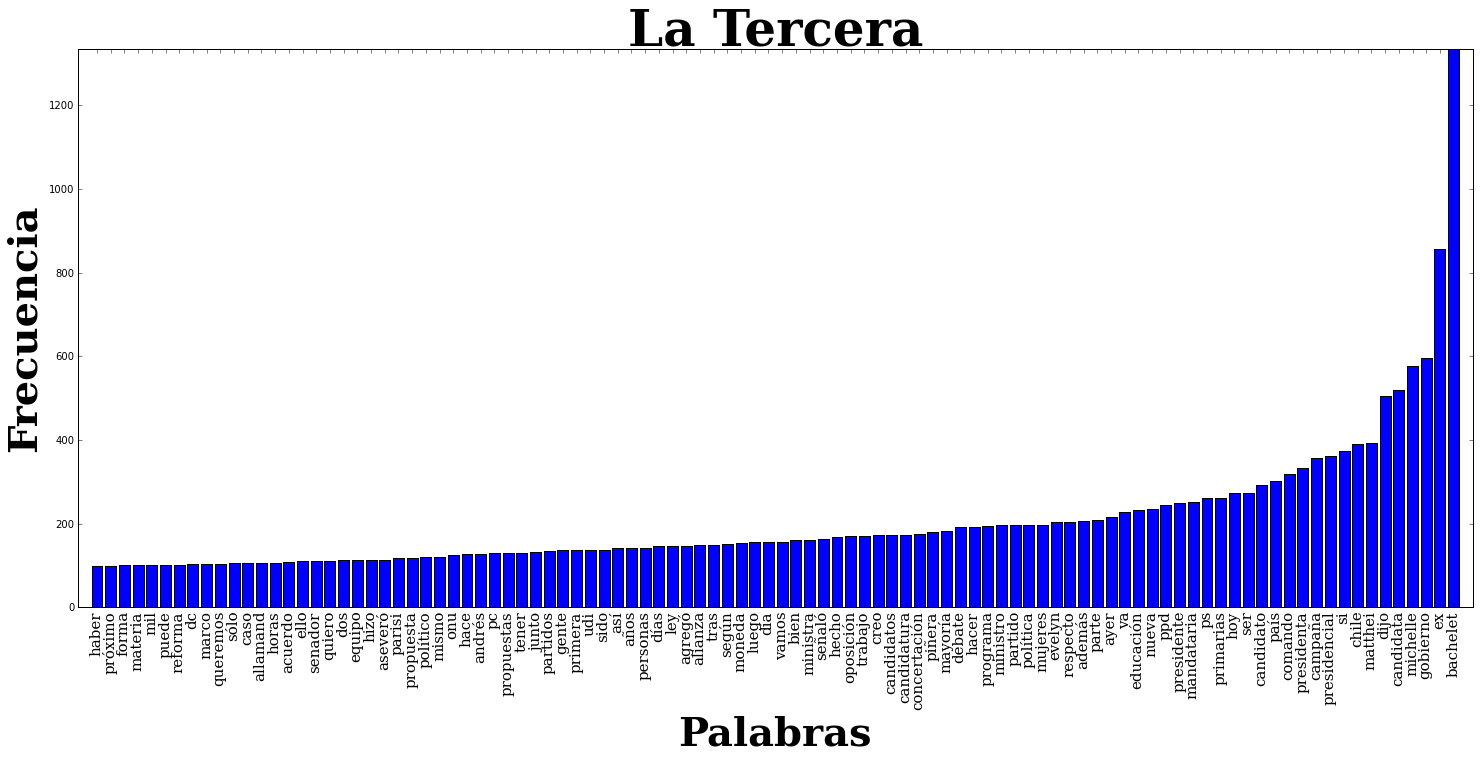

Datos: 100


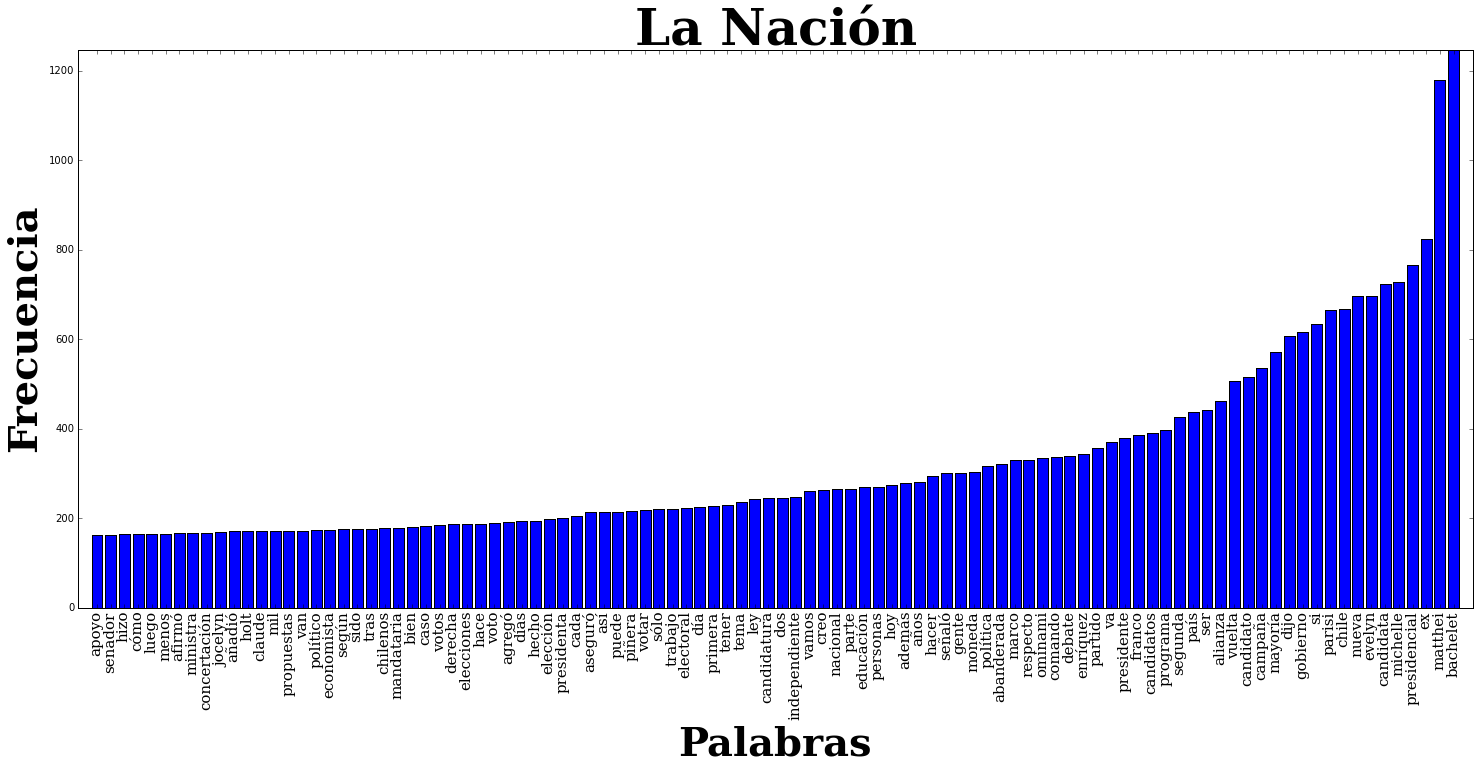

Datos: 100


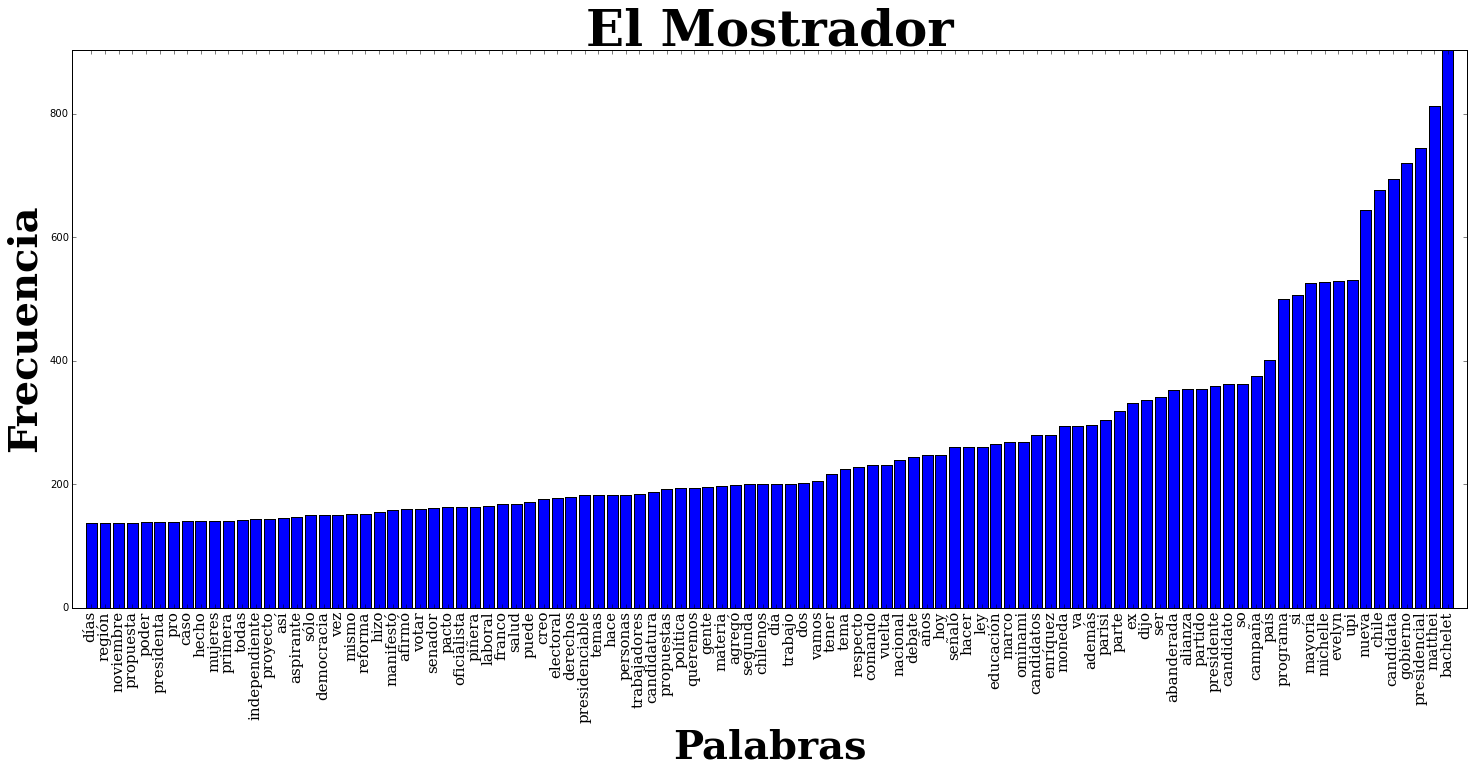

In [25]:
plots=[(emolTopHundred,'Emol'),(ltTopHundred,'La Tercera'),(lnTopHundred,'La Nación'),(emTopHundred,'El Mostrador')]
hfont = {'fontname':'serif'}
for plot in plots:
    D=sorted(plot[0])
    yAxis=[D[i][0] for i in range(len(D))]
    xAxis=[D[i][1] for i in range(len(D))]
    print('Datos:',len(plot[0]))
    
    plt.bar(range(len(D)), yAxis ,align='center')
    plt.xticks(range(len(D)), xAxis ,rotation='vertical', fontsize=15, **hfont)
    plt.title(plot[1], fontsize=50, fontweight='bold', **hfont)
    plt.ylabel('Frecuencia', fontsize=40, fontweight='bold', **hfont)
    plt.xlabel('Palabras', fontsize=40, fontweight='bold', **hfont)
    
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 25
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.margins(0.01,0)
    
    #no activar la siguiente linea pues se guardarán los gráficos en su computador
    plt.savefig(plot[1]+'100',bbox_inches='tight')
    plt.show()
   

### TFIDF

Lo hice sin normalizar por que así salían mejores resultados

In [26]:
tfidfTransformer=sklearn.feature_extraction.text.TfidfTransformer(norm=None)

In [27]:
tfidf=tfidfTransformer.fit_transform(sparseMatrix,y)

### Modelos

Se arman modelos y testean

In [28]:
kTrainTest=sklearn.cross_validation.KFold(len(corpus),5,shuffle=True,random_state=1005)

In [29]:
sparseMatrix_train, sparseMatrix_test, y_train, y_test = sklearn.cross_validation.train_test_split(sparseMatrix, y, \
                                                            test_size=0.3, random_state=42)

In [30]:
tfidfMatrix_train, tfidfMatrix_test, tfidf_y_train, tfidf_y_test = sklearn.cross_validation.train_test_split(tfidf, y, \
                                                            test_size=0.3, random_state=42)

In [31]:
matricesAndName=[(tfidf,'TF-IDF'),(sparseMatrix,'TF')]

### Decision tree

In [32]:
decisionTreeModel=DecisionTreeClassifier()

In [33]:
for matrix in matricesAndName:
    s=[[],[],[],[]]
    avg=[0,0,0,0]
    print('\n {0} :\n'.format(matrix[1]))
    for k, (train, test) in enumerate(kTrainTest):
        decisionTreeModel.fit(matrix[0][train], y[train])
        predict=decisionTreeModel.predict(matrix[0][test])
        recall=sklearn.metrics.recall_score(y[test],predict,average='macro')
        f1=sklearn.metrics.f1_score(y[test],predict,average='macro')
        precision=sklearn.metrics.precision_score(y[test],predict,average='macro')
        accuracy=sklearn.metrics.accuracy_score(y[test],predict)
        print("[fold {0}] recall: {1:.6f} f1_score: {2:.6f}, precision: {3:.6f}, accuracy: {4:.6f}".
              format(k+1, recall, f1, precision, accuracy))
        s[0].append(recall)
        s[1].append(f1)
        s[2].append(precision)
        s[3].append(accuracy)
        avg[0]+=recall
        avg[1]+=f1
        avg[2]+=precision
        avg[3]+=accuracy
    avg=[average/(k+1) for average in avg]
    s=[statistics.pstdev(sd) for sd in s]
    print('\n            [recall] standard deviation:','%.4f'%s[0],'average:','%.4f'%avg[0],\
          '\n                [f1] standard deviation:','%.4f'%s[1],'average:','%.4f'%avg[1],\
          '\n         [precision] standard deviation:','%.4f'%s[2],'average:','%.4f'%avg[2], \
          '\n          [accuracy] standard deviation:','%.4f'%s[3],'average:','%.4f'%avg[3],)
        


 TF-IDF :

[fold 1] recall: 0.802135 f1_score: 0.805157, precision: 0.813280, accuracy: 0.806780
[fold 2] recall: 0.786431 f1_score: 0.785194, precision: 0.786275, accuracy: 0.788136
[fold 3] recall: 0.809456 f1_score: 0.802443, precision: 0.798580, accuracy: 0.813243
[fold 4] recall: 0.799481 f1_score: 0.798216, precision: 0.797117, accuracy: 0.799660
[fold 5] recall: 0.762001 f1_score: 0.764223, precision: 0.768256, accuracy: 0.774194

            [recall] standard deviation: 0.0167 average: 0.7919 
                [f1] standard deviation: 0.0151 average: 0.7910 
         [precision] standard deviation: 0.0149 average: 0.7927 
          [accuracy] standard deviation: 0.0139 average: 0.7964

 TF :

[fold 1] recall: 0.811607 f1_score: 0.814850, precision: 0.824724, accuracy: 0.816949
[fold 2] recall: 0.796027 f1_score: 0.799143, precision: 0.804788, accuracy: 0.805085
[fold 3] recall: 0.818331 f1_score: 0.815785, precision: 0.814173, accuracy: 0.823430
[fold 4] recall: 0.785402 f1_sco

In [34]:
decisionTreeModel.fit(sparseMatrix_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [35]:
y_predicted_tree_tf=decisionTreeModel.predict(sparseMatrix_test)

In [36]:
sklearn.metrics.confusion_matrix(y_test,y_predicted_tree_tf, labels=['emol','la nación','el mostrador','la tercera'])

array([[261,  29,   2,  12],
       [ 26, 171,  11,  41],
       [  5,  21, 157,   6],
       [  8,  22,   4, 109]])

In [38]:
print(sklearn.metrics.classification_report(y_test,y_predicted_tree_tf))

             precision    recall  f1-score   support

el mostrador       0.90      0.83      0.87       189
       emol       0.87      0.86      0.86       304
  la nación       0.70      0.69      0.70       249
 la tercera       0.65      0.76      0.70       143

avg / total       0.79      0.79      0.79       885



In [39]:
decisionTreeModel.fit(tfidfMatrix_train,tfidf_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [40]:
y_predicted_tree_tfidf=decisionTreeModel.predict(tfidfMatrix_test)

In [41]:
print(sklearn.metrics.confusion_matrix(tfidf_y_test,y_predicted_tree_tfidf, labels=['emol','la nación','el mostrador','la tercera']))

[[254  36   1  13]
 [ 22 171  19  37]
 [  3  21 160   5]
 [  5  26   6 106]]


In [42]:
print(sklearn.metrics.classification_report(tfidf_y_test,y_predicted_tree_tfidf, labels=['emol','la nación','el mostrador','la tercera']))

             precision    recall  f1-score   support

       emol       0.89      0.84      0.86       304
  la nación       0.67      0.69      0.68       249
el mostrador       0.86      0.85      0.85       189
 la tercera       0.66      0.74      0.70       143

avg / total       0.79      0.78      0.78       885



### Logistic regression

In [114]:
logisticRegressionModel=sklearn.linear_model.LogisticRegression()

In [44]:
for matrix in matricesAndName:
    s=[[],[],[],[]]
    avg=[0,0,0,0]
    print('\n {0} :\n'.format(matrix[1]))
    for k, (train, test) in enumerate(kTrainTest):
        logisticRegressionModel.fit(matrix[0][train], y[train])
        predict=logisticRegressionModel.predict(matrix[0][test])
        recall=sklearn.metrics.recall_score(y[test],predict,average='macro')
        f1=sklearn.metrics.f1_score(y[test],predict,average='macro')
        precision=sklearn.metrics.precision_score(y[test],predict,average='macro')
        accuracy=sklearn.metrics.accuracy_score(y[test],predict)
        print("[fold {0}] recall: {1:.6f} f1_score: {2:.6f}, precision: {3:.6f}, accuracy: {4:.6f}".
              format(k+1, recall, f1, precision, accuracy))
        s[0].append(recall)
        s[1].append(f1)
        s[2].append(precision)
        s[3].append(accuracy)
        avg[0]+=recall
        avg[1]+=f1
        avg[2]+=precision
        avg[3]+=accuracy
    avg=[average/(k+1) for average in avg]
    s=[statistics.pstdev(sd) for sd in s]
    print('\n            [recall] standard deviation:','%.4f'%s[0],'average:','%.4f'%avg[0],\
          '\n                [f1] standard deviation:','%.4f'%s[1],'average:','%.4f'%avg[1],\
          '\n         [precision] standard deviation:','%.4f'%s[2],'average:','%.4f'%avg[2], \
          '\n          [accuracy] standard deviation:','%.4f'%s[3],'average:','%.4f'%avg[3],)
    


 TF-IDF :

[fold 1] recall: 0.818347 f1_score: 0.827569, precision: 0.841888, accuracy: 0.825424
[fold 2] recall: 0.795118 f1_score: 0.802932, precision: 0.813521, accuracy: 0.801695
[fold 3] recall: 0.837801 f1_score: 0.844635, precision: 0.852757, accuracy: 0.838710
[fold 4] recall: 0.776461 f1_score: 0.785062, precision: 0.798441, accuracy: 0.780985
[fold 5] recall: 0.789908 f1_score: 0.802113, precision: 0.819743, accuracy: 0.796265

            [recall] standard deviation: 0.0218 average: 0.8035 
                [f1] standard deviation: 0.0210 average: 0.8125 
         [precision] standard deviation: 0.0196 average: 0.8253 
          [accuracy] standard deviation: 0.0207 average: 0.8086

 TF :

[fold 1] recall: 0.864917 f1_score: 0.870839, precision: 0.879179, accuracy: 0.872881
[fold 2] recall: 0.839228 f1_score: 0.844265, precision: 0.850363, accuracy: 0.844068
[fold 3] recall: 0.856154 f1_score: 0.863229, precision: 0.871543, accuracy: 0.859083
[fold 4] recall: 0.819868 f1_sco

In [45]:
logisticRegressionModel.fit(sparseMatrix_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [46]:
y_predicted_log=logisticRegressionModel.predict(sparseMatrix_test)

In [47]:
sklearn.metrics.confusion_matrix(y_test,y_predicted_log, labels=['emol','la nación','el mostrador','la tercera'])

array([[273,  25,   0,   6],
       [ 29, 197,  10,  13],
       [ 12,  22, 153,   2],
       [  5,  25,   1, 112]])

In [48]:
print(sklearn.metrics.classification_report(y_test,y_predicted_log, labels=['emol','la nación','el mostrador','la tercera']))

             precision    recall  f1-score   support

       emol       0.86      0.90      0.88       304
  la nación       0.73      0.79      0.76       249
el mostrador       0.93      0.81      0.87       189
 la tercera       0.84      0.78      0.81       143

avg / total       0.84      0.83      0.83       885



In [49]:
logisticRegressionModel.fit(tfidfMatrix_train,tfidf_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [50]:
y_predicted_log_tfidf=logisticRegressionModel.predict(tfidfMatrix_test)

In [51]:
print(sklearn.metrics.confusion_matrix(tfidf_y_test,y_predicted_log_tfidf, labels=['emol','la nación','el mostrador','la tercera']))

[[259  32   6   7]
 [ 33 189  18   9]
 [ 15  25 147   2]
 [ 10  22   3 108]]


### Naive

In [52]:
naiveBayesModel=MultinomialNB()

In [53]:
for matrix in matricesAndName:
    s=[[],[],[],[]]
    avg=[0,0,0,0]
    print('\n {0} :\n'.format(matrix[1]))
    for k, (train, test) in enumerate(kTrainTest):
        naiveBayesModel.fit(matrix[0][train], y[train])
        predict=naiveBayesModel.predict(matrix[0][test])
        recall=sklearn.metrics.recall_score(y[test],predict,average='macro')
        f1=sklearn.metrics.f1_score(y[test],predict,average='macro')
        precision=sklearn.metrics.precision_score(y[test],predict,average='macro')
        accuracy=sklearn.metrics.accuracy_score(y[test],predict)
        print("[fold {0}] recall: {1:.6f} f1_score: {2:.6f}, precision: {3:.6f}, accuracy: {4:.6f}".
              format(k+1, recall, f1, precision, accuracy))
        s[0].append(recall)
        s[1].append(f1)
        s[2].append(precision)
        s[3].append(accuracy)
        avg[0]+=recall
        avg[1]+=f1
        avg[2]+=precision
        avg[3]+=accuracy
    avg=[average/(k+1) for average in avg]
    s=[statistics.pstdev(sd) for sd in s]
    print('\n            [recall] standard deviation:','%.4f'%s[0],'average:','%.4f'%avg[0],\
          '\n                [f1] standard deviation:','%.4f'%s[1],'average:','%.4f'%avg[1],\
          '\n         [precision] standard deviation:','%.4f'%s[2],'average:','%.4f'%avg[2], \
          '\n          [accuracy] standard deviation:','%.4f'%s[3],'average:','%.4f'%avg[3],)
        


 TF-IDF :

[fold 1] recall: 0.556127 f1_score: 0.566557, precision: 0.581512, accuracy: 0.544068
[fold 2] recall: 0.541814 f1_score: 0.550174, precision: 0.561734, accuracy: 0.528814
[fold 3] recall: 0.601412 f1_score: 0.591696, precision: 0.590137, accuracy: 0.573854
[fold 4] recall: 0.478775 f1_score: 0.485462, precision: 0.497236, accuracy: 0.468591
[fold 5] recall: 0.533367 f1_score: 0.539514, precision: 0.548760, accuracy: 0.519525

            [recall] standard deviation: 0.0395 average: 0.5423 
                [f1] standard deviation: 0.0353 average: 0.5467 
         [precision] standard deviation: 0.0327 average: 0.5559 
          [accuracy] standard deviation: 0.0345 average: 0.5270

 TF :

[fold 1] recall: 0.585141 f1_score: 0.602174, precision: 0.635652, accuracy: 0.588136
[fold 2] recall: 0.597998 f1_score: 0.616902, precision: 0.657225, accuracy: 0.598305
[fold 3] recall: 0.631512 f1_score: 0.641032, precision: 0.666322, accuracy: 0.631579
[fold 4] recall: 0.546714 f1_sco

In [54]:
naiveBayesModel.fit(sparseMatrix_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [55]:
y_predicted_nb=naiveBayesModel.predict(sparseMatrix_test)

In [56]:
sklearn.metrics.confusion_matrix(y_test,y_predicted_nb, labels=['emol','la nación','el mostrador','la tercera'])

array([[229,  38,  31,   6],
       [108, 105,  33,   3],
       [ 58,  30, 101,   0],
       [ 43,  15,   1,  84]])

In [57]:
print(sklearn.metrics.classification_report(y_test,y_predicted_nb, labels=['emol','la nación','el mostrador','la tercera']))

             precision    recall  f1-score   support

       emol       0.52      0.75      0.62       304
  la nación       0.56      0.42      0.48       249
el mostrador       0.61      0.53      0.57       189
 la tercera       0.90      0.59      0.71       143

avg / total       0.61      0.59      0.58       885



In [58]:
naiveBayesModel.fit(tfidfMatrix_train,tfidf_y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [59]:
y_predicted_nb_tfidf=naiveBayesModel.predict(tfidfMatrix_test)

In [60]:
print(sklearn.metrics.confusion_matrix(tfidf_y_test,y_predicted_nb_tfidf, labels=['emol','la nación','el mostrador','la tercera']))

[[175  58  53  18]
 [ 77 118  45   9]
 [ 50  42  95   2]
 [ 29  15   5  94]]


# Bonus 1

El crawler busca y guarda archivos json en la carpeta en que se encuentra, hay que mover estos archivos para que funcione.

In [115]:
from html5lib.sanitizer import HTMLSanitizerMixin

In [116]:
with open('emolbonus.json') as data_file:
    emoldctrybonus=json.load(data_file)
    
with open('latercerabonus.json') as data_file:
    laterceradctrybonus=json.load(data_file)

In [117]:
nwspprsbonus=[emoldctrybonus]

In [118]:
contentsbonus=[]
ybonus=[]
for newspaper in nwspprsbonus:
    for article in newspaper:
        contentsbonus.append(article['content'])
        if (newspaper==emoldctrybonus):
            ybonus.append('emol')
        elif (newspaper==lndctrybonus):
            ybonus.append('la nación')
        elif (newspaper==emdctrybonus):
            ybonus.append('el mostrador')
        elif (newspaper==ltdctrybonus):
            ybonus.append('la tercera')
ybonus=numpy.asarray(ybonus) 

In [119]:
contentsbonus[0]

'<div>"Si el próximo 24 de mayo (reunión del Eurogrupo) conseguimos lo que queremos en relación con la deuda, en 2017 podremos volver a los mercados, y tal vez podamos dejar atrás los programas de rescate mucho antes de que finalice el actual memorando (agosto de 2018)", afirma Tsipras en una entrevista con la edición dominical del diario Real News.</div><div>Según la autoridad, una vez que Grecia logre cerrar con sus socios esta primera evaluación del rescate "se cierra un círculo y Grecia entrará en una nueva era".</div><div>En la entrevista, Tsipras evita señalar si este paquete preventivo, que se legislará la semana próxima, contendrá nuevas reducciones de salarios y pensiones, como ha exigido el FMI, pero deja claro que "en ningún caso no incluye despidos en el sector público".</div><div>Tsipras dice estar convencido de que no será necesario "activar" este mecanismo en los próximos tres años, pues hasta 2019 la economía griega habrá logrado repuntar "cerca de siete puntos", ya que

In [129]:
documentTokensbonus=[]
stopwords=nltk.corpus.stopwords.words('spanish')
for article in contentsbonus:
    text=gensim.utils.decode_htmlentities(article)
    tokens=gensim.utils.simple_preprocess(text)
    tokens=[token for token in tokens]
    documentTokensbonus.append(tokens)

In [130]:
documentTokensbonus

[['div',
  'si',
  'el',
  'próximo',
  'de',
  'mayo',
  'reunión',
  'del',
  'eurogrupo',
  'conseguimos',
  'lo',
  'que',
  'queremos',
  'en',
  'relación',
  'con',
  'la',
  'deuda',
  'en',
  'podremos',
  'volver',
  'los',
  'mercados',
  'tal',
  'vez',
  'podamos',
  'dejar',
  'atrás',
  'los',
  'programas',
  'de',
  'rescate',
  'mucho',
  'antes',
  'de',
  'que',
  'finalice',
  'el',
  'actual',
  'memorando',
  'agosto',
  'de',
  'afirma',
  'tsipras',
  'en',
  'una',
  'entrevista',
  'con',
  'la',
  'edición',
  'dominical',
  'del',
  'diario',
  'real',
  'news',
  'div',
  'div',
  'según',
  'la',
  'autoridad',
  'una',
  'vez',
  'que',
  'grecia',
  'logre',
  'cerrar',
  'con',
  'sus',
  'socios',
  'esta',
  'primera',
  'evaluación',
  'del',
  'rescate',
  'se',
  'cierra',
  'un',
  'círculo',
  'grecia',
  'entrará',
  'en',
  'una',
  'nueva',
  'era',
  'div',
  'div',
  'en',
  'la',
  'entrevista',
  'tsipras',
  'evita',
  'señalar',
  'si',

In [131]:
labelDictionarybonus=gensim.corpora.dictionary.Dictionary()

In [132]:
corpusbonus=[]
for document in documentTokensbonus:
    corpusbonus.append(labelDictionary.doc2bow(document))

In [133]:
sparseMatrixbonus=gensim.matutils.corpus2csc(corpusbonus)

In [134]:
sparseMatrixbonus=sparseMatrixbonus.transpose()

In [135]:
sparseMatrixbonus

<105x25538 sparse matrix of type '<class 'numpy.float64'>'
	with 7952 stored elements in Compressed Sparse Row format>

In [127]:
logisticRegressionModel.fit(sparseMatrix,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [128]:
predicted_bonus=logisticRegressionModel.predict(sparseMatrixbonus)

ValueError: X has 25538 features per sample; expecting 25594